<a href="https://colab.research.google.com/github/Ali-Felfel/DeepLearning/blob/main/Chest_X_Ray_After_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
iimport tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Concatenate, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.regularizers import l1_l2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive'  # take a look at the Google Drive content

Mounted at /content/gdrive
MyDrive


In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!unzip '/content/gdrive/MyDrive/archive/chest_xray/fake/XRayNormalFakeA1' -d '/content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL'

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5000.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5001.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5002.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5003.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5004.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5005.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5006.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5007.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/NORMAL/XRay_generated 5008.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GA

In [ ]:
!unzip '/content/gdrive/MyDrive/archive/chest_xray/fake/XRayPneumonialFake' -d '/content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA'

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5000.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5001.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5002.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5003.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5004.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5005.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5006.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5007.png  
 extracting: /content/gdrive/MyDrive/archive/chest_xray/GAN_Train/PNEUMONIA/XRay_generated 5008.png  
 extracting: /content/gdrive/My

## 1. Importing and Exploring Data

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/chest_xray/GAN_Train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 20000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/archive/chest_xray/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 624 images belonging to 2 classes.


In [ ]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#2.Callbacks

In [ ]:
filepath = './best_weights.hdf5'


earlystopping = EarlyStopping(monitor = 'val_acc', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]


## 3. CNN1 - basic model

In [ ]:
# Initialising the CNN
classifier1 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier1.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier1.add(MaxPooling2D((2, 2)))

classifier1.add(Flatten())

classifier1.add(Dense(units = 128, activation = 'relu'))
classifier1.add(Dense(units = 1, activation = 'sigmoid'))



In [ ]:
classifier1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [ ]:
classifier1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist1=classifier1.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.3038 - acc: 0.8531
Epoch 1: val_acc improved from -inf to 0.87179, saving model to ./best_weights.hdf5
164/164 [==============================] - 239s 1s/step - loss: 0.3038 - acc: 0.8531 - val_loss: 0.4853 - val_acc: 0.8718
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.0842 - acc: 0.9705
Epoch 2: val_acc did not improve from 0.87179
164/164 [==============================] - 59s 363ms/step - loss: 0.0842 - acc: 0.9705 - val_loss: 1.6811 - val_acc: 0.7131
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.0347 - acc: 0.9901
Epoch 3: val_acc did not improve from 0.87179
164/164 [==============================] - 61s 372ms/step - loss: 0.0347 - acc: 0.9901 - val_loss: 1.6868 - val_acc: 0.6811
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.0452 - acc: 0.9842
Epoch 4: val_acc did not improve from 0.87179
164/164 [==============================] - 5

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = classifier1.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[125 109]
 [ 13 377]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.91      0.53      0.67       234
   PNEUMONIA       0.78      0.97      0.86       390

    accuracy                           0.80       624
   macro avg       0.84      0.75      0.77       624
weighted avg       0.82      0.80      0.79       624



In [ ]:
acc = hist1.history['acc']
val_acc = hist1.history['val_acc']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

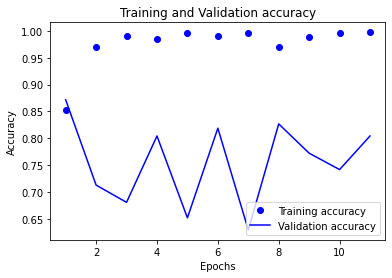

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

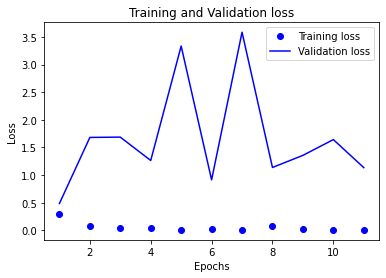

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 4. CNN2 - with Dropout

In [ ]:
# Initialising the CNN
classifier2 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier2.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier2.add(MaxPooling2D((2, 2)))
classifier2.add(Dropout(rate=0.25))

classifier2.add(Flatten())

classifier2.add(Dense(units = 128, activation = 'relu'))
classifier2.add(Dropout(rate=0.5))
classifier2.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)       

In [ ]:
classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist2=classifier2.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.5771 - acc: 0.6846
Epoch 1: val_acc did not improve from 0.87179
164/164 [==============================] - 61s 366ms/step - loss: 0.5771 - acc: 0.6846 - val_loss: 0.4110 - val_acc: 0.8237
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.2258 - acc: 0.9129
Epoch 2: val_acc did not improve from 0.87179
164/164 [==============================] - 59s 362ms/step - loss: 0.2258 - acc: 0.9129 - val_loss: 0.4097 - val_acc: 0.8429
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.1407 - acc: 0.9491
Epoch 3: val_acc did not improve from 0.87179
164/164 [==============================] - 59s 362ms/step - loss: 0.1407 - acc: 0.9491 - val_loss: 0.7632 - val_acc: 0.7740
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.1319 - acc: 0.9499
Epoch 4: val_acc did not improve from 0.87179
164/164 [==============================] - 58s 357ms/step - loss: 0.1319 - acc: 

In [ ]:
Y_pred = classifier2.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 82 152]
 [  8 382]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.91      0.35      0.51       234
   PNEUMONIA       0.72      0.98      0.83       390

    accuracy                           0.74       624
   macro avg       0.81      0.66      0.67       624
weighted avg       0.79      0.74      0.71       624



In [ ]:
acc = hist2.history['acc']
val_acc = hist2.history['val_acc']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

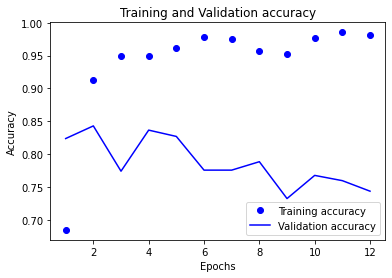

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

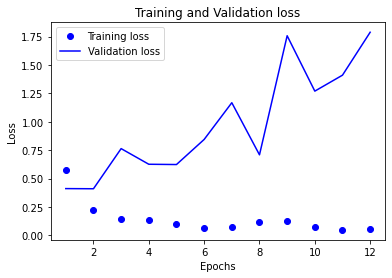

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. CNN3 - with Dropout and BatchNormalization


Similar to cnn_2, but with BatchNormalization.
Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural 
network, and in some cases improves the performance of the model via a modest regularization effect.

In [ ]:
# Initialising the CNN
classifier3 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier3.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier3.add(MaxPooling2D((2, 2)))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.25))

classifier3.add(Flatten())

classifier3.add(Dense(units = 128, activation = 'relu'))
classifier3.add(BatchNormalization())
classifier3.add(Dropout(rate=0.5))
classifier3.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)      

In [ ]:
classifier3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist3=classifier3.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.0855 - acc: 0.9726
Epoch 1: val_acc did not improve from 0.87179
164/164 [==============================] - 63s 371ms/step - loss: 0.0855 - acc: 0.9726 - val_loss: 2.6596 - val_acc: 0.6250
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.0139 - acc: 0.9954
Epoch 2: val_acc did not improve from 0.87179
164/164 [==============================] - 59s 357ms/step - loss: 0.0139 - acc: 0.9954 - val_loss: 4.6315 - val_acc: 0.6250
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.0071 - acc: 0.9979
Epoch 3: val_acc did not improve from 0.87179
164/164 [==============================] - 60s 365ms/step - loss: 0.0071 - acc: 0.9979 - val_loss: 4.3130 - val_acc: 0.6250
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.0021 - acc: 0.9996
Epoch 4: val_acc did not improve from 0.87179
164/164 [==============================] - 59s 359ms/step - loss: 0.0021 - acc: 

In [ ]:
Y_pred = classifier3.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 46 188]
 [232 158]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.17      0.20      0.18       234
   PNEUMONIA       0.46      0.41      0.43       390

    accuracy                           0.33       624
   macro avg       0.31      0.30      0.30       624
weighted avg       0.35      0.33      0.34       624



In [ ]:
acc = hist3.history['acc']
val_acc = hist3.history['val_acc']
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

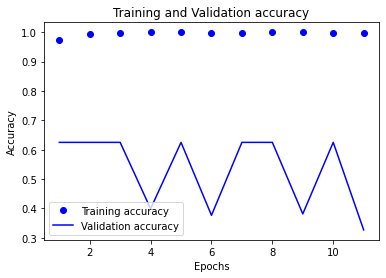

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

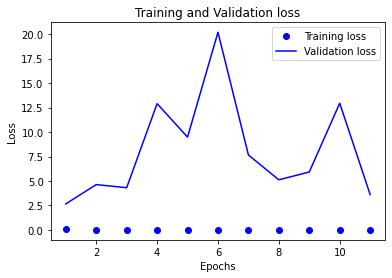

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. CNN4 - with Dropout, BatchNormalization and two conv layers in a row.

This is something possible and commonly used in very challenging tasks.
The idea of having two (or more) conv layers is to perform a more in-depth analysis of local patterns of the image.
There is no rule for deciding if two consecutive conv layers are better than a conv layer followed by a pooling layer.

In [ ]:
# Initialising the CNN
classifier4 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier4.add(Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier4.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
classifier4.add(Conv2D(64, (3, 3), padding='same'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier4.add(MaxPooling2D((2, 2)))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.25))

classifier4.add(Flatten())

classifier4.add(Dense(units = 128, activation = 'relu'))
classifier4.add(BatchNormalization())
classifier4.add(Dropout(rate=0.5))
classifier4.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 73, 73, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 73, 73, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 73, 73, 32)       

In [ ]:
classifier4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist4=classifier4.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.0928 - acc: 0.9663
Epoch 1: val_acc did not improve from 0.87179
164/164 [==============================] - 65s 380ms/step - loss: 0.0928 - acc: 0.9663 - val_loss: 1.0125 - val_acc: 0.2981
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.0144 - acc: 0.9949
Epoch 2: val_acc did not improve from 0.87179
164/164 [==============================] - 62s 380ms/step - loss: 0.0144 - acc: 0.9949 - val_loss: 6.2386 - val_acc: 0.3766
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.0018 - acc: 0.9998
Epoch 3: val_acc did not improve from 0.87179
164/164 [==============================] - 63s 385ms/step - loss: 0.0018 - acc: 0.9998 - val_loss: 3.9108 - val_acc: 0.3429
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 6.7717e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 0.87179
164/164 [==============================] - 63s 382ms/step - loss: 6.7717e-04

In [ ]:
Y_pred = classifier4.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[  0 234]
 [  0 390]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc = hist4.history['acc']
val_acc = hist4.history['val_acc']
loss = hist4.history['loss']
val_loss = hist4.history['val_loss']

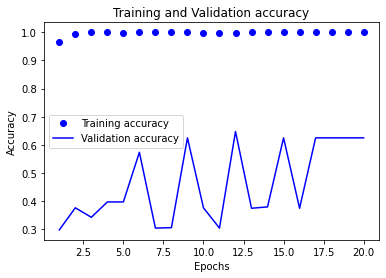

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

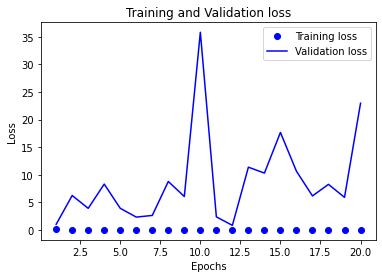

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. CNN5 - Same as CNN4, but with regularizers (L1 and L2).

In [ ]:
# Initialising the CNN
classifier5 = Sequential()

In [ ]:
l1_cnn_5 = 0.001
l2_cnn_5 = 0.001

In [ ]:
# Step 1 - Convolution
classifier5.add(Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer = regularizers.l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier5.add(MaxPooling2D((2, 2)))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.25))

classifier5.add(Flatten())

classifier5.add(Dense(units = 128, activation = 'relu'))
classifier5.add(BatchNormalization())
classifier5.add(Dropout(rate=0.5))
classifier5.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 conv2d_15 (Conv2D)          (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 73, 73, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 73, 73, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 73, 73, 32)       

In [ ]:
classifier5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist5=classifier5.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 1.3735 - acc: 0.9724
Epoch 1: val_acc did not improve from 0.87179
164/164 [==============================] - 70s 408ms/step - loss: 1.3735 - acc: 0.9724 - val_loss: 3.8592 - val_acc: 0.6250
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.8084 - acc: 0.9941
Epoch 2: val_acc did not improve from 0.87179
164/164 [==============================] - 66s 405ms/step - loss: 0.8084 - acc: 0.9941 - val_loss: 7.0545 - val_acc: 0.6250
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.4679 - acc: 0.9970
Epoch 3: val_acc did not improve from 0.87179
164/164 [==============================] - 66s 404ms/step - loss: 0.4679 - acc: 0.9970 - val_loss: 4.3404 - val_acc: 0.6250
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.2884 - acc: 0.9960
Epoch 4: val_acc did not improve from 0.87179
164/164 [==============================] - 66s 401ms/step - loss: 0.2884 - acc: 

In [ ]:
Y_pred = classifier5.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[  0 234]
 [  0 390]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc = hist5.history['acc']
val_acc = hist5.history['val_acc']
loss = hist5.history['loss']
val_loss = hist5.history['val_loss']

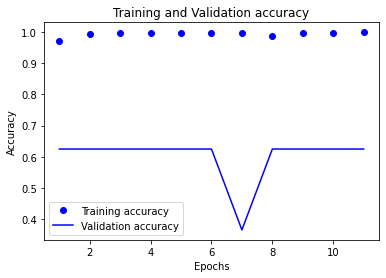

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

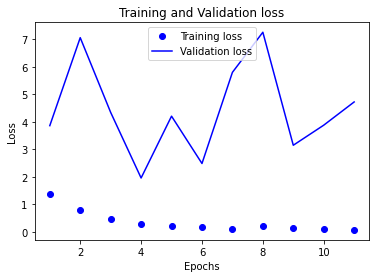

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. CNN6 - Similar to cnn1, but with 256 units in the fully-connected layer, and 64 batches in the fit.


In [ ]:
# Initialising the CNN
classifier6 = Sequential()

In [ ]:
# Step 1 - Convolution
classifier6.add(Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
classifier6.add(MaxPooling2D((2, 2)))

classifier6.add(Flatten())

classifier6.add(Dense(units = 256, activation = 'relu'))
classifier6.add(Dense(units = 1, activation = 'sigmoid'))


In [ ]:
classifier6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 74, 74, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 37, 37, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 37, 37, 256)       295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 18, 18, 256)     

In [ ]:
classifier6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
hist6=classifier6.fit(training_set,
                         steps_per_epoch = 164, # since batch_size=32 -> steps_per_epoch=5232/32 = 163.5
                         epochs = 20,
                         callbacks=callback_list,
                         validation_data = test_set,
                         validation_steps = 20)  # 624/32 = 19.5

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.5334 - acc: 0.7309
Epoch 1: val_acc improved from 0.87179 to 0.87981, saving model to ./best_weights.hdf5
164/164 [==============================] - 66s 393ms/step - loss: 0.5334 - acc: 0.7309 - val_loss: 0.3395 - val_acc: 0.8798
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.1441 - acc: 0.9472
Epoch 2: val_acc did not improve from 0.87981
164/164 [==============================] - 61s 372ms/step - loss: 0.1441 - acc: 0.9472 - val_loss: 0.3145 - val_acc: 0.8798
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.0755 - acc: 0.9714
Epoch 3: val_acc did not improve from 0.87981
164/164 [==============================] - 60s 363ms/step - loss: 0.0755 - acc: 0.9714 - val_loss: 0.4362 - val_acc: 0.8478
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 0.0777 - acc: 0.9714
Epoch 4: val_acc did not improve from 0.87981
164/164 [==============================

In [ ]:
Y_pred = classifier6.predict(test_set, 20) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[161  73]
 [ 15 375]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.91      0.69      0.79       234
   PNEUMONIA       0.84      0.96      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



In [ ]:
acc = hist6.history['acc']
val_acc = hist6.history['val_acc']
loss = hist6.history['loss']
val_loss = hist6.history['val_loss']

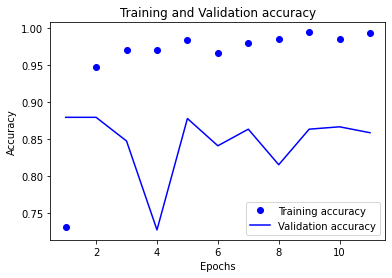

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

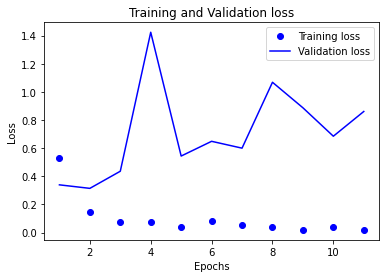

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()